# Test 7: 50 MB/sec

## producer config

~~~~
limit_bytes_per_seconds=$(( 50 * 1024 * 1024 ))
-Dnum.producers=8 \
-Dproducer.threads=16 \
-Dmin.msg.size=175 \
-Dmax.msg.size=225 \

[kafka.config]
{
security.protocol=SASL_PLAINTEXT,
receive.buffer.bytes=2097152,
request.timeout.ms=6000,
bootstrap.servers=host1.com:9092,host2.com:9092,host3.com:9092,
value.serializer=org.apache.kafka.common.serialization.ByteArraySerializer,
send.buffer.bytes=2097152,
buffer.memory=536870912,
retries=0,
key.serializer=org.apache.kafka.common.serialization.IntegerSerializer,
client.id=testproducer-001,
linger.ms=200,
sasl.mechanism=PLAIN,
max.in.flight.requests.per.connection=16,
batch.size=131072,
max.block.ms=20000,
acks=1
}
~~~~

## consumer config
~~~~
-Dconsumer.threads=32

[kafka.config]
{
security.protocol=SASL_PLAINTEXT,
receive.buffer.bytes=1048576,
partition.assignment.strategy=org.apache.kafka.clients.consumer.RoundRobinAssignor,
value.deserializer=org.apache.kafka.common.serialization.ByteArrayDeserializer,
group.id=stem-dmaap-testconsumer,
bootstrap.servers=host1.com:9092,host2.com:9092,host3.com:9092,
send.buffer.bytes=1048576,
max.partition.fetch.bytes=5242880,
fetch.max.wait.ms=5000,
client.id=testconsumer-001,
key.deserializer=org.apache.kafka.common.serialization.IntegerDeserializer,
sasl.mechanism=PLAIN,
fetch.min.bytes=16384
}
~~~~

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, os.path
import numpy as np

In [2]:
plt.xkcd(scale=1, length=100, randomness=1)

In [3]:
DATA_DIR='data'

In [4]:
def load_data(csvfile, datadir):
    d = pd.read_csv(os.path.join(datadir, csvfile))
    d['datetime'] = pd.to_datetime(d.date + " " + d.time.str.slice(0,5), 
                                   format="%Y-%m-%d %H:%M") # upto minute only
    d.set_index('datetime', inplace=True)
    return d

def fix_ax(ax):
    ax.set_xlabel('')
    ax.axes.grid(linewidth=0.5)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    return ax

def test_duration_in_hours(t0, t1):
    #print "{} start({}) end({}) {} hours".format(tag, t0, t1, int((t1 - t0).total_seconds()/60/60))
    return int((t1 - t0).total_seconds()/60/60)

In [5]:
data_dir = os.path.join(DATA_DIR, '7')
#data_dir

In [6]:
consumer = load_data('consumer.csv', data_dir)
#consumer.head()

In [7]:
producer = load_data('producer.csv', data_dir)
#producer.head()

## Test Duration

In [8]:
limit=50 # MB
interval = 5  # minutes
freq = '%dT' % interval

delta = pd.Timedelta(4, 'h')
#delta = pd.Timedelta(0, 'h')

consumer2 = consumer[consumer.index <= consumer.index.max() - delta]
producer2 = producer[producer.index <= producer.index.max() - delta]

# 
start = consumer2.index.min()
end = consumer2.index.max()
duration = int((end - start).total_seconds()/60/60)

metdata = pd.DataFrame.from_records(
    zip("start end duration limit interval".split(), (start, end, duration, limit, interval)),
    columns=('name','value'))

metdata.to_csv(os.path.join(data_dir,'metadata.txt'), index=False)

metdata

,name,value
0,start,2018-07-31 14:56:00
1,end,2018-08-01 05:21:00
2,duration,14
3,limit,50
4,interval,5


## Throughput

,count,mean,std,min,25%,50%,75%,max
consumer,172.0,252716.57,319.23,250076.0,252713.75,252758.0,252798.00,253301.0
producer,172.0,252717.16,317.63,250088.0,252724.00,252758.5,252787.25,253243.0


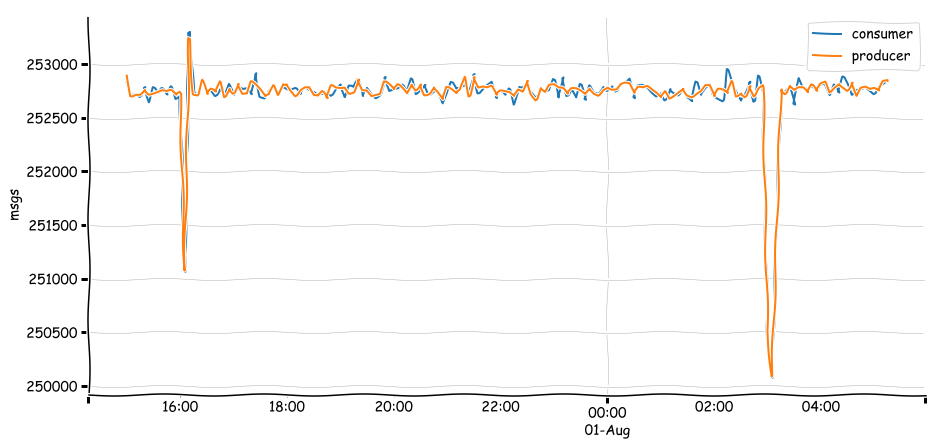

In [9]:
keys = ['consumer','producer']
df = pd.concat([consumer2[['msgs']], producer2[['msgs']]],
               keys=keys,
               axis=1
               )

df2 = df.groupby(pd.Grouper(freq=freq))
df2 = df2.sum()
df2 = df2/(interval*60) # per seconds
df2 = df2.round(2).astype(int)
df2 = df2[1:-1]
df2.columns = df2.columns.droplevel(1)
ax = df2.plot(subplots=False, figsize=(15,7))
fix_ax(ax)
ax.set_ylabel("msgs")
plt.savefig(os.path.join(data_dir, 'img', 'throughput-msgs.svg'))
df3 = df2.describe().T.round(2)
df3.to_csv(os.path.join(data_dir, 'throughput-msgs.txt'), index_label=['type'])
df3

,count,mean,std,min,25%,50%,75%,max
consumer,172.0,50.01,0.06,49.49,50.01,50.02,50.03,50.12
producer,172.0,50.01,0.06,49.49,50.01,50.02,50.02,50.11


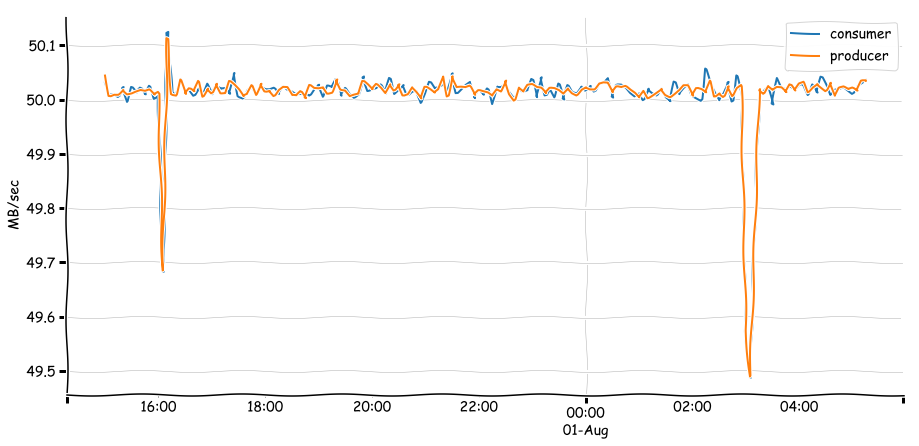

In [10]:
keys=['consumer','producer']
df = pd.concat([consumer2[['bytes']], producer2[['bytes']]],
               keys=keys,
               axis=1)
df2 = df.groupby(pd.Grouper(freq=freq)).sum()
df2 = df2[1:-1]/1024/1024/(interval*60)
df2.columns = df2.columns.droplevel(1)

ax = df2.plot(figsize=(15,7), subplots=False, legend=True)

fix_ax(ax)
ax.set_ylabel("MB/sec")
plt.savefig(os.path.join(data_dir, 'img', 'throughput.svg'))

df3 = df2.describe().T.round(2)
df3.to_csv(os.path.join(data_dir, 'throughput.txt'), index_label=['type'])
df3

## Latency

In [11]:
"{1}{0}".format(*"a,b,c".split(","))

'ba'

count    mean    std    min     25%    50%     75%  \
type     percentile                                                       
consumer p95         172.0  648.14  11.85  624.6  640.40  648.0  655.05   
         p99         172.0  907.49  28.30  873.0  894.55  905.8  917.10   
producer p95         172.0  297.33   6.22  284.6  293.40  296.7  300.60   
         p99         172.0  430.23   9.00  410.0  425.60  430.4  435.25   

                        max  
type     percentile          
consumer p95          714.4  
         p99         1203.4  
producer p95          330.8  
         p99          477.0

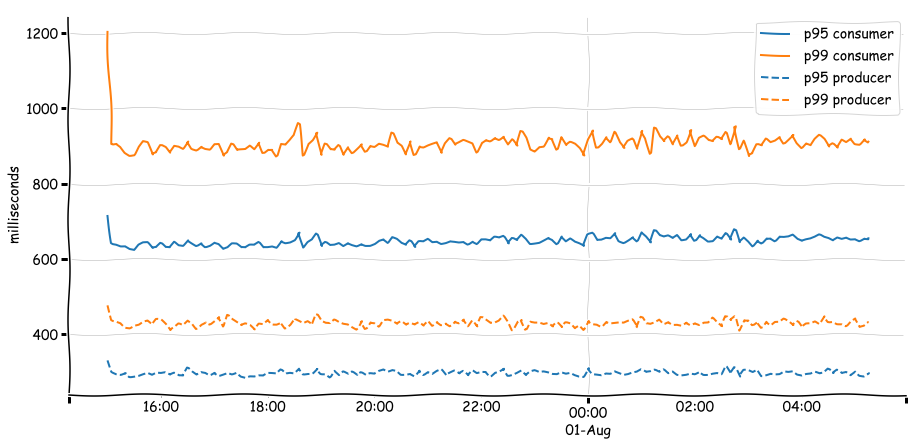

In [12]:
def lat_histo_p(d):
    d = d[d.columns[d.columns.str.startswith('lat_histo_p')]]
    d.columns = d.columns.str.replace('lat_histo_','')
    return d[1:-1]

df = pd.concat([lat_histo_p(consumer2), lat_histo_p(producer2)],
               keys=['consumer','producer'],
               names=['type'],
               axis=1
              )

df2 = df.loc[:, (slice(None), ('p95','p99'))]
df2 = df2.groupby(pd.Grouper(freq=freq)).mean().round(2)
df2 = df2[1:-1]

ax = df2.plot(figsize=(15,7), 
              subplots=False, 
              sharex=True, 
              sharey=True,
              style=['-','-','--','--'],
              color=['#1f77b4', '#ff7f0e']
             )
fix_ax(ax)
ax.legend().set_title('')
ax.set_ylabel('milliseconds')

handles, labels = ax.get_legend_handles_labels()
labels = map(lambda s: "{1} {0}".format(*s[1:-1].split(",")), labels)
ax.legend(handles, labels)

plt.savefig(os.path.join(data_dir, 'img', 'latency.svg'))

df3 = df2.describe().round(2).T
df3.index.names = ['type','percentile']
df3.to_csv(os.path.join(data_dir, 'latency.txt'))
df3

0 days 18:25:00
start=2018-07-31 14:56:00 end=2018-08-01 09:21:00
ploting start=2018-07-31 14:56:00 end=2018-08-01 09:21:00 interval=0 days 18:25:00


Text(0.5,1,'end-to-end latency\nstart=07/31 14:56 | end=08/01 09:21 | interval=18.42 hrs')

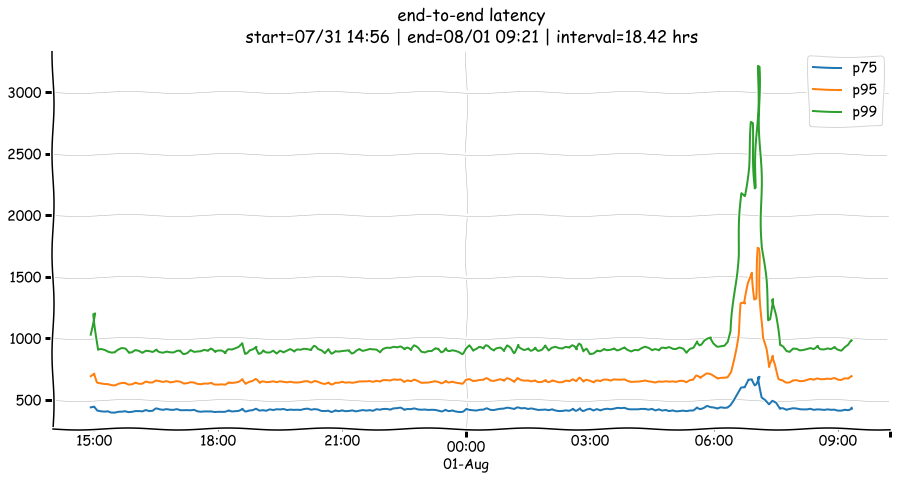

In [13]:
print consumer.index.max() - consumer.index.min()
#start = consumer.index.max() - pd.Timedelta(10, unit='m') # 'ns', 'us', 'ms', 's', 'm', 'h', 'D'
start = consumer.index.min() + pd.Timedelta(0, unit='m')
end   = consumer.index.max() - pd.Timedelta(0, unit='m')
print "start={} end={}".format(start, end)
consumer2 = consumer[np.logical_and(consumer.index >= start, consumer.index <= end)]
print "ploting start={} end={} interval={}".format(consumer2.index.min(), consumer2.index.max(),
                                   consumer2.index.max() - consumer2.index.min())
ax = lat_histo_p(consumer2)[['p75', 'p95','p99']].groupby(pd.Grouper(freq='5T')).mean().plot(figsize=(15,7))
fix_ax(ax)
plt.savefig(os.path.join(data_dir, 'img', 'latency-zoom.svg'))
ax.set_title("end-to-end latency\nstart={} | end={} | interval={} hrs".format(
    consumer2.index.min().strftime("%m/%d %H:%M"), 
    consumer2.index.max().strftime("%m/%d %H:%M"), 
    round((consumer2.index.max() - consumer2.index.min()).total_seconds()/60/60,2)
))

## Success

,msgs,success,error
datetime,,,
2018-07-31 12:00:00,965953542,965953496,0
2018-07-31 16:00:00,3639372646,3639352135,20269
2018-07-31 20:00:00,3639753621,3639753424,0
2018-08-01 00:00:00,3637828733,3637828564,0
2018-08-01 04:00:00,1243720977,1243720909,0


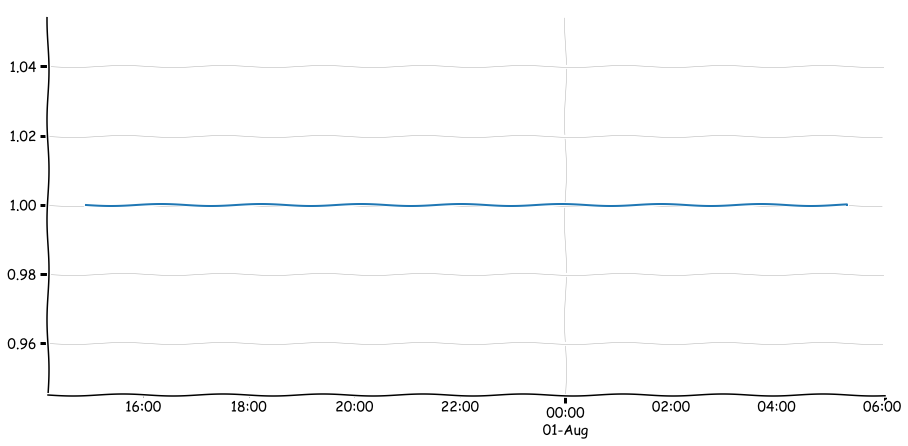

In [14]:
df = pd.DataFrame({
    'success': producer2.apply(lambda row: row.msgs if row.success > row.msgs else row.success, axis=1),
    'msgs'   : producer2.msgs, 
    'error'  : producer2.error,
    }, 
    index=producer2.index)
df['success_ratio']=df.success/df.msgs

df2 = df['success_ratio'].groupby(pd.Grouper(freq=freq)).mean().round(3)
axes = df2.plot(figsize=(15,7), legend=False)
axes = map(fix_ax, [axes])
plt.savefig(os.path.join(data_dir, 'img', 'success.svg'))

df3 = df[['msgs','success','error']].groupby(pd.Grouper(freq='4H')).sum()
df3.to_csv(os.path.join(data_dir, 'success.txt'))
df3